In [1]:
import warnings
warnings.filterwarnings(action='ignore')

# Method 1: Feature Extraction

Similar to `AutoTokenizer`, `AutoModel` loads pretrained moel's weight.

In [2]:
import torch
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

If you wish to implement interoperability and utilize `TensorFlow`.

Use `TFAutoModel` in `transformers`, instead of `AutoModel`.

`from_pt=True` argument enables user to load PyTorch model into TensorFlow using its weights.

## Employ the last hidden state
Pretrained model does:
* Text data -> Token encoding -> Token embedding -> Encoder Stack -> Hidden state

User implements:
* Get hidden state from model -> Classification head -> Prediction

### Part 1: Pretrained model

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [4]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor size: {inputs['input_ids'].size()}")

Input tensor size: torch.Size([1, 6])


The above tensor size represents `[batch_size, n_tokens]`.

Without `return_tensors="pt"`, Python `list` will be returned.

In [5]:
inputs = { k:v.to(device) for k,v in inputs.items() }
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [6]:
print("last_hidden_state.size():", outputs.last_hidden_state.size())
print("last_hidden_state[:,0].size():", outputs.last_hidden_state[:,0].size())

last_hidden_state.size(): torch.Size([1, 6, 768])
last_hidden_state[:,0].size(): torch.Size([1, 768])


#### Let's perform process on whole dataset

In [7]:
def extract_hidden_states(batch):
    # Move model input tensor to gpu
    inputs = { k:v.to(device) for k,v in batch.items()
                if k in tokenizer.model_input_names }
    
    # Extract the last hidden state
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    
    # return the vector for [CLS] token
    return { "hidden_state": last_hidden_state[:,0].cpu().numpy() }

In [8]:
from datasets import load_dataset

emotions = load_dataset("emotion")

In [9]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
emotions_encoded.set_format("torch",
                            columns = ["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [11]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Part 2: User implementation

Preprocessed dataset now contains complete information for classification model.

* `hidden state`: input feature
* `Label`: target

In [12]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### Train set visualization

In [13]:
import pandas as pd
from umap.umap_ import UMAP
from sklearn.preprocessing import MinMaxScaler

# scale the feature to [0,1]
X_scaled = MinMaxScaler().fit_transform(X_train)
# Generate and train UMAP object
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# 2D embedding --> DataFrame
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.284726,6.404689,0
1,-3.100737,5.545366,0
2,5.249702,2.887582,3
3,-2.340260,3.579125,2
4,-3.319653,3.852195,3


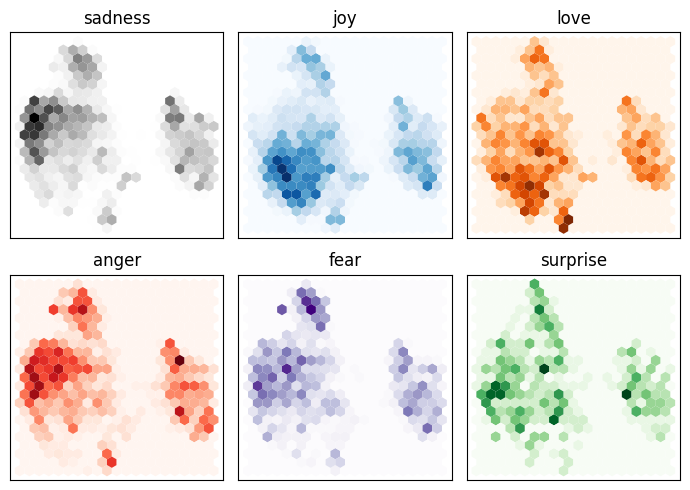

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### Simple Classification Model Training
`Logistic regression` is simple, fast, and doesn't need GPU.

In [15]:
from sklearn.linear_model import LogisticRegression

# increase `max_iter` to ensure convergence.
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6355

Compare with `DummyClassifier`.

Kind of being baseline.

In [16]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [17]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.185

#### Confusion matrix

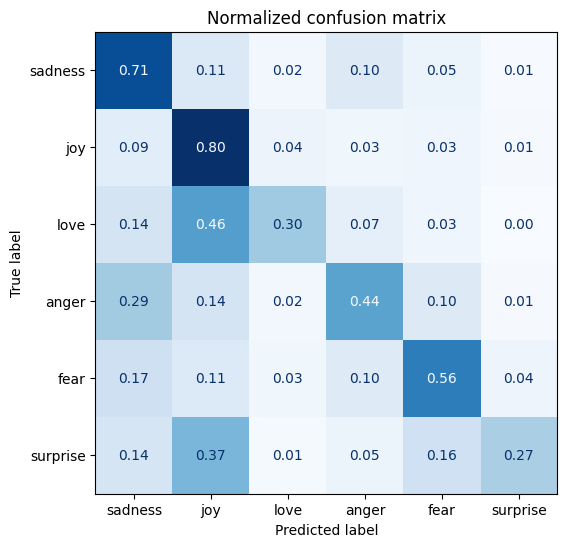

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

# Method 2: Fine-tuning

Fine-tune the pretrained models to enhance the classification performance from previous approach.

### Step 1: Load pretrained model

In [19]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* The above cell may print warning on not initialized weights; it's completely normal as the head is not trained yet.

### Set metrics

In [20]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

### Train model

In [28]:
from huggingface_hub import notebook_login

notebook_login()

In [29]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"])  # batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  load_best_model_at_end=True,
                                  log_level="error")

In [30]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

TrainOutput(global_step=500, training_loss=0.5253059692382812, metrics={'train_runtime': 147.1719, 'train_samples_per_second': 217.433, 'train_steps_per_second': 3.397, 'train_loss': 0.5253059692382812, 'epoch': 2.0})

In [39]:
pd.DataFrame(trainer.state.log_history).iloc[:2].dropna(axis='columns')

,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.303583,0.9075,0.907322,2.4755,807.908,12.927,1.0,250
1,0.209203,0.9240,0.923814,2.4210,826.098,13.218,2.0,500


In [32]:
preds_output = trainer.predict(emotions_encoded["validation"])

  0%|          | 0/32 [00:00<?, ?it/s]

In [33]:
preds_output.metrics

{'test_loss': 0.20920279622077942,
 'test_accuracy': 0.924,
 'test_f1': 0.9238140372502702,
 'test_runtime': 2.8105,
 'test_samples_per_second': 711.609,
 'test_steps_per_second': 11.386}

In [40]:
y_preds = np.argmax(preds_output.predictions, axis=1)   # best guess(i.e. y_pred) for each input row

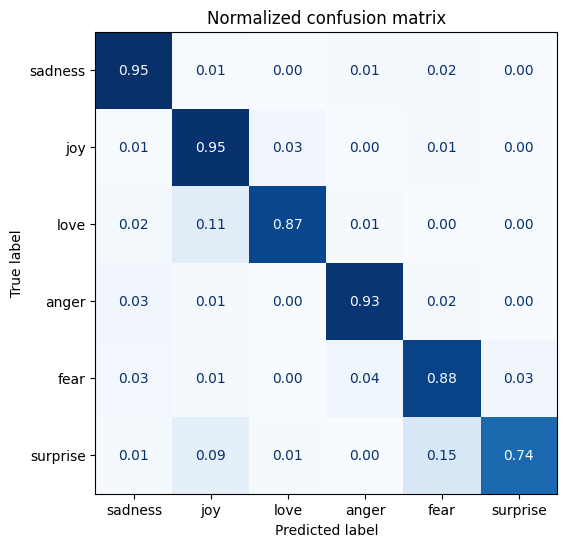

In [43]:
plot_confusion_matrix(y_preds, y_valid, labels)

### Loss Analysis

In [45]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Move input tensors to the same device as model
    inputs = { k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names }
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
        
    # Move back to cpu device, so that the return features can interact/match with other columns.
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

`map()` the above function to get every sample's loss.

In [46]:
# Format dataset into pytorch tensor
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

# Compute loss
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [47]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [48]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

Order the dataframe by loss to capture:
* `Wrong label`: It is absolutely normal to have wrong label. If it was easy to label, you wouldn't even need a model. Loss value helps user to readily capture such labels.
* `Significance of dataset`: Sometimes, a model is affected by very significant elements, such as special characters or certain strings. Looking into the worst prediction helps user to improve data cleaning and sample preprocessing.

In [49]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1274,i am going to several holiday parties and i ca...,joy,sadness,5.399679
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.382768
1963,i called myself pro life and voted for perry w...,joy,sadness,5.310859
765,i feel super awkward and out of place right now,joy,sadness,5.297578
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.212873
465,i would eventually go in to these stores but i...,joy,fear,4.973530
882,i feel badly about reneging on my commitment t...,love,sadness,4.945958
1950,i as representative of everything thats wrong ...,surprise,sadness,4.772357
1111,im lazy my characters fall into categories of ...,joy,fear,4.770032
1801,i feel that he was being overshadowed by the s...,love,sadness,4.742545


In [50]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.019362
1657,i get up to refill my coffee and feel that ple...,joy,joy,0.019535
632,i feel he is an terrific really worth bet,joy,joy,0.019547
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.019565
578,i got to christmas feeling positive about the ...,joy,joy,0.019568
1544,i feel that my charlie card is much more valua...,joy,joy,0.019688
1263,i feel this way about blake lively,joy,joy,0.019691
845,i already feel very glamorous have a great day...,joy,joy,0.019788
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.019868
856,i feel is more energetic in urban singapore th...,joy,joy,0.019939


# Upload my Model

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")